In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import statistics
from scipy.optimize import curve_fit
import math 
from scipy.stats import binom
import seaborn as sns
from scipy import stats
import matplotlib.patches as mpatches
from scipy.stats import beta

In [3]:
df = pd.read_csv (r'/home/emonroe/Downloads/20210531_toEM/behavior_csv/senor_clean_contingencies_only_parsed_data.csv')

In [4]:
df['day']= df['date'].ne(df['date'].shift()).cumsum()
#df['diff_cont'] = df.groupby(['day','session'],group_keys=True)['contingency']

for ix in range(len(df)):
    if df.loc[ix,'trial']<60:
        df.loc[ix,'cont_num']=1
    elif df.loc[ix,'trial']>119:
        df.loc[ix,'cont_num']=3
    else:
        df.loc[ix,'cont_num'] =2

#df['diff_cont'] = df.

#df['diff_cont'] = df['contingency'].ne(df['contingency'].shift())


#df['cont_num'] = df.groupby(['day','session'])['diff_cont'].cumsum()
# del df['diff_cont']
# df['new_cont'] = df['cont_num'].ne(df['cont_num'].shift())
df['day_chng'] = df['day'].ne(df['day'].shift())
df['stem_switch'] = df['stem'].ne(df['stem'].shift())
df['bout_num'] = df['stem'].ne(df['stem'].shift()).cumsum()



# df["stemChange"] = (df["stem"].shift(1, fill_value=df["stem"].head(1)) != df["stem"]).astype(int) #better way to calc?
for ix in range(len(df)):
    cont= str(df.loc[ix, 'contingency'])
    cont = [cont[i:i+2] for i in range(0, len(cont), 2)]
    cont = [int(i) for i in cont]
    df.loc[ix, 'glob_nom_avg'] = statistics.mean(cont)
df['sess_chng'] = df['session'].ne(df['session'].shift()).cumsum()
df['sess_chng'] = df['session'].ne(df['session'].shift()).cumsum()
obj = ['day', 'session', 'stem']

df['rew_count'] = df.groupby(obj)[['reward']].cumsum()
df[0:5]

,Unnamed: 0,leaf,stem,reward,contingency,date,session,trial,day,cont_num,day_chng,stem_switch,bout_num,glob_nom_avg,sess_chng,rew_count
0,0,4,B,1,805020202050,20201028,1,0,1,1.0,True,True,1,40.0,1,1
1,1,1,A,0,805020202050,20201028,1,1,1,1.0,False,True,2,40.0,1,0
2,2,2,A,0,805020202050,20201028,1,2,1,1.0,False,False,2,40.0,1,0
3,3,3,B,1,805020202050,20201028,1,3,1,1.0,False,True,3,40.0,1,2
4,4,4,B,0,805020202050,20201028,1,4,1,1.0,False,False,3,40.0,1,2


In [5]:
df.loc[df.stem == "A", "ChooseA"] = '1'
df.loc[df.stem == "B", "ChooseB"] = '1'
df.loc[df.stem == "C", "ChooseC"] = '1'
df['ChooseA'] = df['ChooseA'].fillna(0)
df['ChooseB'] = df['ChooseB'].fillna(0)
df['ChooseC'] = df['ChooseC'].fillna(0)
df

,Unnamed: 0,leaf,stem,reward,contingency,date,session,trial,day,cont_num,day_chng,stem_switch,bout_num,glob_nom_avg,sess_chng,rew_count,ChooseA,ChooseB,ChooseC
0,0,4,B,1,805020202050,20201028,1,0,1,1.0,True,True,1,40.0,1,1,0,1,0
1,1,1,A,0,805020202050,20201028,1,1,1,1.0,False,True,2,40.0,1,0,1,0,0
2,2,2,A,0,805020202050,20201028,1,2,1,1.0,False,False,2,40.0,1,0,1,0,0
3,3,3,B,1,805020202050,20201028,1,3,1,1.0,False,True,3,40.0,1,2,0,1,0
4,4,4,B,0,805020202050,20201028,1,4,1,1.0,False,False,3,40.0,1,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13288,13288,2,A,1,508020208020,20201107,6,175,11,3.0,False,False,814,45.0,74,28,1,0,0
13289,13289,1,A,0,508020208020,20201107,6,176,11,3.0,False,False,814,45.0,74,28,1,0,0
13290,13290,2,A,0,508020208020,20201107,6,177,11,3.0,False,False,814,45.0,74,28,1,0,0
13291,13291,1,A,1,508020208020,20201107,6,178,11,3.0,False,False,814,45.0,74,29,1,0,0


In [6]:
#at the end of these three cells, a new df with the first three stems visits, beta stats for each of those, and the fourth chosen stem. 

lst_means_1=[]
lst_means_2=[]
lst_means_3=[]
lst_var_1=[]
lst_var_2=[]
lst_var_3=[]
lst_skew_1=[]
lst_skew_2=[]
lst_skew_3=[]
lst_kurt_1=[]
lst_kurt_2=[]
lst_kurt_3=[]
trials_1=[]
trials_2=[]
trials_3=[]
fourth = []
first_stem1=[]
second_stem1=[]
third_stem1=[]
cont_num1=[]
for ix in range(1,(df['sess_chng']).max()):
    random_session = df[df['sess_chng']==ix]
    random_session = random_session[random_session['cont_num']==1]
    bout = random_session[random_session.stem_switch==1]
    cont_nom=random_session.contingency.iloc[0]
    first_stem=bout['stem'].iloc[0]
    if len(bout)>1:
        second_stem=bout['stem'].iloc[1]
    else: 
        second_stem = first_stem
    if len(bout)>2:
        third_stem = bout['stem'].iloc[2]
    else: 
        third_stem = second_stem
    if len(bout) > 3:
        fourth_stem = bout['stem'].iloc[3]
        fourth_bout_num = random_session.bout_num.min()+3
        fourth_bout_len = len(random_session.loc[random_session.bout_num==fourth_bout_num])
    else:
        fourth_stem=third_stem
    first_bout_num = random_session.bout_num.min()
    first_bout = random_session.loc[random_session.bout_num==first_bout_num]
    #first_stem1=first_bout.iloc[0]['stem']
    chose1=len(first_bout)
    second_bout_num = random_session.bout_num.min()+1
    second_bout = random_session.loc[random_session.bout_num==second_bout_num]
    #second_stem1=second_bout.iloc[0]['stem']
    chose2=len(second_bout)
    third_bout_num = random_session.bout_num.min()+2
    third_bout = random_session.loc[random_session.bout_num==third_bout_num]
    #third_stem1=third_bout.iloc[0]['stem']
    chose3=len(third_bout)
    first_bout_beta_data_s = first_bout['reward'].sum()
    first_bout_beta_data_f = len(first_bout)-first_bout_beta_data_s
    second_bout_beta_data_s = second_bout['reward'].sum()
    second_bout_beta_data_f = len(second_bout)-second_bout_beta_data_s
    third_bout_beta_data_s = third_bout['reward'].sum()
    third_bout_beta_data_f = len(third_bout)-third_bout_beta_data_s
    x = np.linspace(0, 1, 10000)
    mean_1, var_1, skew_1, kurt_1 = beta.stats(first_bout_beta_data_s+1, first_bout_beta_data_f+1, moments='mvsk')
    mean_2, var_2, skew_2, kurt_2 = beta.stats(second_bout_beta_data_s+1, second_bout_beta_data_f+1, moments='mvsk')
    mean_3, var_3, skew_3, kurt_3 = beta.stats(third_bout_beta_data_s+1, third_bout_beta_data_f+1, moments='mvsk')
    lst_means_1.append(mean_1)
    lst_means_2.append(mean_2)
    lst_means_3.append(mean_3)
    lst_var_1.append(var_1)
    lst_var_2.append(var_2)
    lst_var_3.append(var_3)
    lst_skew_1.append(skew_1)
    lst_skew_2.append(skew_2)
    lst_skew_3.append(skew_3)
    lst_kurt_1.append(kurt_1)
    lst_kurt_2.append(kurt_2)
    lst_kurt_3.append(kurt_3)
    trials_1.append(chose1)
    trials_2.append(chose2)
    trials_3.append(chose3)
    fourth.append(fourth_stem)
    first_stem1+=(first_stem)
    second_stem1+=(second_stem)
    third_stem1+=(third_stem)
    cont_num1.append(cont_nom)
    
    
    #     ax.set_title(f"PDF of Beta; #success={a-1},#failures={b-1} (red)", fontsize=20)
    #     ax.set_xlabel("X", fontsize=16)
    #     ax.set_ylabel("Probability Density", fontsize=16)
#     plt.figure()
#     plt.plot(x, y1.pdf(x), linewidth=3, color='firebrick')
#     plt.plot(x, y2.pdf(x), linewidth=3, color='black')
#     plt.plot(x, y3.pdf(x), linewidth=3, color='purple',alpha=.5)
#     plt.xlabel('x')
#     plt.ylabel('probability distribution')
#     plt.title(f'beta dist for first three stems visited--{cont_nom}')
#     plt.legend([first_stem,second_stem,third_stem,fourth_stem])
#     plt.annotate(f'stem4={fourth_stem}-{fourth_bout_len}',xy=(.7,2))
#     #plt.annotate(f'stem1={first_stem}-red-{len(first_bout)}\nstem2={second_stem}-black-{len(second_bout)}\nstem3={third_stem}-purple-{len(third_bout)}\nstem4={fourth_stem}-{fourth_bout_len}',xy=(0,2))

In [7]:
new_lst= [lst_means_1,lst_means_2,lst_means_3,lst_var_1,lst_var_2,lst_var_3,lst_skew_1,lst_skew_2,lst_skew_3,lst_kurt_1,lst_kurt_2,lst_kurt_3,trials_1,trials_2,trials_3,fourth,first_stem1,second_stem1,third_stem1,cont_num1]
#new_lst

In [8]:
df_beta = pd.DataFrame(new_lst)
df_beta = pd.DataFrame.transpose(df_beta)
df_beta.columns =['1_mean', '2_mean', '3_mean','1_var', '2_var', '3_var','1_skew', '2_skew', '3_skew','1_kurt', '2_kurt', '3_kurt','trials_1','trials_2','trials_3','fourth stem', 'first_stem','second_stem', 'third_stem','cont_num']

df_beta
#should ask- what is the average for each of the stems in the kurtosis plot- is kurtosis always higher at an 8050 forexample? 
#should plot all three stems, variance vs kurtosis 
#which bout is it when the rat first exploits? 

,1_mean,2_mean,3_mean,1_var,2_var,3_var,1_skew,2_skew,3_skew,1_kurt,2_kurt,3_kurt,trials_1,trials_2,trials_3,fourth stem,first_stem,second_stem,third_stem,cont_num
0,0.6666666666666666,0.25,0.5,0.05555555555555555,0.0375,0.05,-0.565685424949238,0.8606629658238704,0.0,-0.6,0.09523809523809523,-0.8571428571428571,1,2,2,C,B,A,B,805020202050
1,0.25,0.3333333333333333,0.5,0.0375,0.031746031746031744,0.05,0.8606629658238704,0.46770717334674267,0.0,0.09523809523809523,-0.375,-0.8571428571428571,2,4,2,C,C,A,B,502020805080
2,0.5,0.16666666666666666,0.5,0.05,0.01984126984126984,0.03571428571428572,0.0,1.1832159566199232,0.0,-0.8571428571428571,1.2,-0.6666666666666666,2,4,4,C,C,A,B,202080502080
3,0.4,0.3333333333333333,0.16666666666666666,0.04,0.05555555555555555,0.01984126984126984,0.2857142857142857,0.565685424949238,1.1832159566199232,-0.6428571428571429,-0.6,1.2,3,1,4,A,A,B,C,508050208020
4,0.5,0.6666666666666666,0.3333333333333333,0.05,0.031746031746031744,0.031746031746031744,0.0,-0.46770717334674267,0.46770717334674267,-0.8571428571428571,-0.375,-0.375,2,4,4,B,B,C,A,202020505080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.25,0.6666666666666666,0.45454545454545453,0.0375,0.011695906432748537,0.02066115702479339,0.8606629658238704,-0.3082207001484488,0.09730085108210398,0.09523809523809523,-0.15,-0.4153846153846154,2,16,9,A,A,C,B,805020202080
69,0.5,0.42857142857142855,0.2222222222222222,0.03571428571428572,0.030612244897959183,0.01728395061728395,0.0,0.18144368465060579,0.768322049753197,-0.6666666666666666,-0.5555555555555556,0.3116883116883117,4,5,7,B,B,A,C,205080205020
70,0.5,0.5714285714285714,0.2857142857142857,0.05,0.030612244897959183,0.025510204081632654,0.0,-0.18144368465060579,0.5962847939999439,-0.8571428571428571,-0.5555555555555556,-0.12,2,5,5,B,A,C,B,208080505020
71,0.5714285714285714,0.2857142857142857,0.6888888888888889,0.030612244897959183,0.025510204081632654,0.004659151905528717,-0.18144368465060579,0.5962847939999439,-0.23551312233753194,-0.5555555555555556,-0.12,-0.043533679772526715,5,5,43,B,A,C,A,502020505080


In [9]:
second_stem1

['A',
 'A',
 'A',
 'B',
 'C',
 'C',
 'A',
 'A',
 'C',
 'B',
 'A',
 'C',
 'A',
 'A',
 'C',
 'A',
 'A',
 'A',
 'A',
 'C',
 'C',
 'C',
 'C',
 'C',
 'B',
 'C',
 'B',
 'C',
 'A',
 'A',
 'C',
 'C',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'C',
 'A',
 'C',
 'C',
 'A',
 'C',
 'A',
 'C',
 'C',
 'A',
 'A',
 'A',
 'C',
 'C',
 'A',
 'C',
 'C',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'B',
 'B',
 'C',
 'A',
 'A',
 'C',
 'A',
 'C',
 'C',
 'C']

In [31]:
#for every line of df_beta, find the highest mean, find which stem has the highest mean, and see if the fourth 
#stem is the highest mean of the first three. 
#should probably only do when stems 1,2,3 are different from eachother and when fourth stem is different from third,etc. 


In [10]:
go_to_best=[]
for ix in range(len(df_beta)):
    one = df_beta.iloc[ix]['1_mean']
    two =df_beta.iloc[ix]['2_mean']
    three = df_beta.iloc[ix]['3_mean']
    lst = [one,two,three]
    max_mean_df = pd.DataFrame(lst)
    max_stem = max_mean_df.idxmax()[0]

    if max_stem ==0:
        best_stem = df_beta.iloc[ix]['first_stem']
    elif max_stem ==1:
        best_stem = df_beta.iloc[ix]['second_stem']
    elif max_stem ==2:
        best_stem = df_beta.iloc[ix]['third_stem']

    if best_stem ==  df_beta.iloc[ix]['fourth stem']:
        go_to_best.append(1)
    else:
        go_to_best.append(0)

In [ ]:
go_to_best

Text(0.5, 1.0, 'does he go to best of first 3 on fourth? 0 or 1')

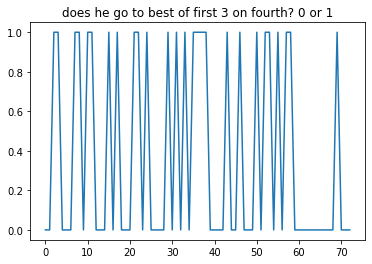

In [12]:
plt.plot(go_to_best) 
plt.title('does he go to best of first 3 on fourth? 0 or 1')
#okay, doesnt aquire the stretegy to go to the best from first three visited. 

In [13]:
#how often does he go repeat stem in first three bouts? 
stem_repeat = []
for ix in range(len(df_beta)):
    one = df_beta.iloc[ix]['first_stem']
    two =df_beta.iloc[ix]['second_stem']
    three = df_beta.iloc[ix]['third_stem']
    one_two = one==two
    one_three = one==three
    two_three = two==three
    is_equal = [one_two,one_three,two_three]
    stem_repeat.append(is_equal)
#not very often, so he normally visits all three 

In [14]:
stem_repeat

[[False, True, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, True, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, True],
 [False, False, False],
 [False, False, True],
 [False, False, False],
 [False, True, False

In [15]:
df_8080 = df[df['glob_nom_avg']==45]
df_8080 = df_8080[df_8080['cont_num']==1]

In [16]:
df_8080['sess_change']=  df_8080['session'].ne(df_8080['session'].shift()).cumsum()

In [17]:
df_8080

,Unnamed: 0,leaf,stem,reward,contingency,date,session,trial,day,cont_num,day_chng,stem_switch,bout_num,glob_nom_avg,sess_chng,rew_count,ChooseA,ChooseB,ChooseC,sess_change
360,360,6,C,1,202080502080,20201028,3,0,1,1.0,False,True,53,45.0,3,1,0,0,1,1
361,361,5,C,0,202080502080,20201028,3,1,1,1.0,False,False,53,45.0,3,1,0,0,1,1
362,362,1,A,0,202080502080,20201028,3,2,1,1.0,False,True,54,45.0,3,0,1,0,0,1
363,363,2,A,0,202080502080,20201028,3,3,1,1.0,False,False,54,45.0,3,0,1,0,0,1
364,364,1,A,0,202080502080,20201028,3,4,1,1.0,False,False,54,45.0,3,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12808,12808,2,A,0,502020505080,20201107,4,55,11,1.0,False,False,794,45.0,72,1,1,0,0,17
12809,12809,1,A,0,502020505080,20201107,4,56,11,1.0,False,False,794,45.0,72,1,1,0,0,17
12810,12810,2,A,0,502020505080,20201107,4,57,11,1.0,False,False,794,45.0,72,1,1,0,0,17
12811,12811,4,B,0,502020505080,20201107,4,58,11,1.0,False,True,795,45.0,72,3,0,1,0,17


In [18]:
random_session = df_8080[df_8080['sess_change']==10]
#random_session = random_session[random_session['cont_num']==1]

In [19]:
random_session
#which one does he choose to exploit? 
#only look at ones where he exploits for over 30 trials. 

#maybe doing it for each of the leaves individually. 

,Unnamed: 0,leaf,stem,reward,contingency,date,session,trial,day,cont_num,day_chng,stem_switch,bout_num,glob_nom_avg,sess_chng,rew_count,ChooseA,ChooseB,ChooseC,sess_change
5913,5913,4,B,1,208080502020,20201102,4,0,6,1.0,False,True,455,45.0,34,1,0,1,0,10
5914,5914,3,B,0,208080502020,20201102,4,1,6,1.0,False,False,455,45.0,34,1,0,1,0,10
5915,5915,4,B,1,208080502020,20201102,4,2,6,1.0,False,False,455,45.0,34,2,0,1,0,10
5916,5916,3,B,1,208080502020,20201102,4,3,6,1.0,False,False,455,45.0,34,3,0,1,0,10
5917,5917,4,B,1,208080502020,20201102,4,4,6,1.0,False,False,455,45.0,34,4,0,1,0,10
5918,5918,3,B,1,208080502020,20201102,4,5,6,1.0,False,False,455,45.0,34,5,0,1,0,10
5919,5919,4,B,1,208080502020,20201102,4,6,6,1.0,False,False,455,45.0,34,6,0,1,0,10
5920,5920,3,B,1,208080502020,20201102,4,7,6,1.0,False,False,455,45.0,34,7,0,1,0,10
5921,5921,4,B,1,208080502020,20201102,4,8,6,1.0,False,False,455,45.0,34,8,0,1,0,10
5922,5922,2,A,1,208080502020,20201102,4,9,6,1.0,False,True,456,45.0,34,1,1,0,0,10


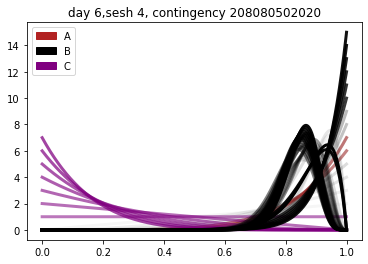

In [21]:

#random_session = df[df['sess_chng']==session]
#random_session = random_session[random_session['cont_num']==1]
#random_session=random_session[0:30]
cont_nom=random_session.contingency.iloc[0]
#         cont_nom=random_session.contingency.iloc[0]
day_nom=random_session.day.iloc[0]
sesh_nom=random_session.session.iloc[0]
plt.figure()
plt.title(f'day {day_nom},sesh {sesh_nom}, contingency {cont_nom}')
A_lst=[]
B_lst=[]
C_lst=[]

for ix in range(len(random_session)):
    #     ix=1
    trial = random_session.iloc[ix]['stem']
    reward = random_session.iloc[ix]['reward']
    if trial == 'A':
        A_lst.append(reward)
    if trial =='B':
        B_lst.append(reward)
    if trial =='C':
        C_lst.append(reward)
    A_s = sum(A_lst)+1
    B_s = sum(B_lst)+1
    C_s = sum(C_lst)+1
    A_f = (len(A_lst)-A_s)+1
    B_f = (len(B_lst)-B_s)+1
    C_f = (len(C_lst)-C_s)+1
    y1 = beta(A_s, A_f)
    y2 = beta(B_s, B_f)
    y3 = beta(C_s, C_f)
        #want to change this so it only plots new line if values is different than last trial. 
    if trial =="A":
        plt.plot(x, y1.pdf(x), linewidth=3, color='firebrick',alpha=ix/30)
    if trial=='B':
        plt.plot(x, y2.pdf(x), linewidth=3, color='black',alpha=ix/30)
    if trial=='C':
         plt.plot(x, y3.pdf(x), linewidth=3, color='purple',alpha=ix/30)
    red_patch = mpatches.Patch(color='firebrick', label='A')
    black_patch= mpatches.Patch(color='black', label='B')
    purple_patch= mpatches.Patch(color='purple', label='C')

    plt.legend(handles=[red_patch, black_patch, purple_patch])
    #plt.annotate(f'{random_session.ChooseA.sum()}  {random_session.ChooseB.sum()}  {random_session.ChooseC.sum()}',xy=(1,2))
#what i notice from this plot- 

#maybe change in rats strategy helps him to separate these distributions earlier
#so that he can stop spending time at worst and have a better idea of which is better
#should use mean and variance, maybe some statistical test about which is actually the best, and see if 
#rat spends more time in the second half at the stem that was best from first half? 

In [22]:
lst_means_1=[]
lst_means_2=[]
lst_means_3=[]
lst_var_1=[]
lst_var_2=[]
lst_var_3=[]
lst_skew_1=[]
lst_skew_2=[]
lst_skew_3=[]
lst_kurt_1=[]
lst_kurt_2=[]
lst_kurt_3=[]
trials_1=[]
trials_2=[]
trials_3=[]
fourth = []
first_stem1=[]
second_stem1=[]
third_stem1=[]
cont_num1=[]
for ix in range(1,(df_8080['sess_change']).max()):
    random_session = df_8080[df_8080['sess_change']==ix]
    random_session = random_session[random_session['cont_num']==1]
    bout = random_session[random_session.stem_switch==1]
    cont_nom=random_session.contingency.iloc[0]
    first_stem=bout['stem'].iloc[0]
    if len(bout)>1:
        second_stem=bout['stem'].iloc[1]
    else: 
        second_stem = first_stem
    if len(bout)>2:
        third_stem = bout['stem'].iloc[2]
    else: 
        third_stem = second_stem
    if len(bout) > 3:
        fourth_stem = bout['stem'].iloc[3]
        fourth_bout_num = random_session.bout_num.min()+3
        fourth_bout_len = len(random_session.loc[random_session.bout_num==fourth_bout_num])
    else:
        fourth_stem=third_stem
    first_bout_num = random_session.bout_num.min()
    first_bout = random_session.loc[random_session.bout_num==first_bout_num]
    #first_stem1=first_bout.iloc[0]['stem']
    chose1=len(first_bout)
    second_bout_num = random_session.bout_num.min()+1
    second_bout = random_session.loc[random_session.bout_num==second_bout_num]
    #second_stem1=second_bout.iloc[0]['stem']
    chose2=len(second_bout)
    third_bout_num = random_session.bout_num.min()+2
    third_bout = random_session.loc[random_session.bout_num==third_bout_num]
    #third_stem1=third_bout.iloc[0]['stem']
    chose3=len(third_bout)
    first_bout_beta_data_s = first_bout['reward'].sum()
    first_bout_beta_data_f = len(first_bout)-first_bout_beta_data_s
    second_bout_beta_data_s = second_bout['reward'].sum()
    second_bout_beta_data_f = len(second_bout)-second_bout_beta_data_s
    third_bout_beta_data_s = third_bout['reward'].sum()
    third_bout_beta_data_f = len(third_bout)-third_bout_beta_data_s
    x = np.linspace(0, 1, 10000)
    mean_1, var_1, skew_1, kurt_1 = beta.stats(first_bout_beta_data_s+1, first_bout_beta_data_f+1, moments='mvsk')
    mean_2, var_2, skew_2, kurt_2 = beta.stats(second_bout_beta_data_s+1, second_bout_beta_data_f+1, moments='mvsk')
    mean_3, var_3, skew_3, kurt_3 = beta.stats(third_bout_beta_data_s+1, third_bout_beta_data_f+1, moments='mvsk')
    lst_means_1.append(mean_1)
    lst_means_2.append(mean_2)
    lst_means_3.append(mean_3)
    lst_var_1.append(var_1)
    lst_var_2.append(var_2)
    lst_var_3.append(var_3)
    lst_skew_1.append(skew_1)
    lst_skew_2.append(skew_2)
    lst_skew_3.append(skew_3)
    lst_kurt_1.append(kurt_1)
    lst_kurt_2.append(kurt_2)
    lst_kurt_3.append(kurt_3)
    trials_1.append(chose1)
    trials_2.append(chose2)
    trials_3.append(chose3)
    fourth.append(fourth_stem)
    first_stem1+=(first_stem)
    second_stem1+=(second_stem)
    third_stem1+=(third_stem)
    cont_num1.append(cont_nom)
    
    
    #     ax.set_title(f"PDF of Beta; #success={a-1},#failures={b-1} (red)", fontsize=20)
    #     ax.set_xlabel("X", fontsize=16)
    #     ax.set_ylabel("Probability Density", fontsize=16)
#     plt.figure()
#     plt.plot(x, y1.pdf(x), linewidth=3, color='firebrick')
#     plt.plot(x, y2.pdf(x), linewidth=3, color='black')
#     plt.plot(x, y3.pdf(x), linewidth=3, color='purple',alpha=.5)
#     plt.xlabel('x')
#     plt.ylabel('probability distribution')
#     plt.title(f'beta dist for first three stems visited--{cont_nom}')
#     plt.legend([first_stem,second_stem,third_stem,fourth_stem])
#     plt.annotate(f'stem4={fourth_stem}-{fourth_bout_len}',xy=(.7,2))
#     #plt.annotate(f'stem1={first_stem}-red-{len(first_bout)}\nstem2={second_stem}-black-{len(second_bout)}\nstem3={third_stem}-purple-{len(third_bout)}\nstem4={fourth_stem}-{fourth_bout_len}',xy=(0,2))

In [23]:
new_lst= [lst_means_1,lst_means_2,lst_means_3,lst_var_1,lst_var_2,lst_var_3,lst_skew_1,lst_skew_2,lst_skew_3,lst_kurt_1,lst_kurt_2,lst_kurt_3,trials_1,trials_2,trials_3,fourth,first_stem1,second_stem1,third_stem1,cont_num1]
#new_lst

In [24]:
df_beta = pd.DataFrame(new_lst)
df_beta = pd.DataFrame.transpose(df_beta)
df_beta.columns =['1_mean', '2_mean', '3_mean','1_var', '2_var', '3_var','1_skew', '2_skew', '3_skew','1_kurt', '2_kurt', '3_kurt','trials_1','trials_2','trials_3','fourth stem', 'first_stem','second_stem', 'third_stem','cont_num']

df_beta

,1_mean,2_mean,3_mean,1_var,2_var,3_var,1_skew,2_skew,3_skew,1_kurt,2_kurt,3_kurt,trials_1,trials_2,trials_3,fourth stem,first_stem,second_stem,third_stem,cont_num
0,0.5,0.16666666666666666,0.5,0.05,0.01984126984126984,0.03571428571428572,0.0,1.1832159566199232,0.0,-0.8571428571428571,1.2,-0.6666666666666666,2,4,4,C,C,A,B,202080502080
1,0.25,0.625,0.25,0.0375,0.026041666666666668,0.0375,0.8606629658238704,-0.30983866769659335,0.8606629658238704,0.09523809523809523,-0.41454545454545455,0.09523809523809523,2,6,2,A,A,B,C,805020202080
2,0.75,0.2857142857142857,0.7142857142857143,0.0375,0.025510204081632654,0.025510204081632654,-0.8606629658238704,0.5962847939999439,-0.5962847939999439,0.09523809523809523,-0.12,-0.12,2,5,5,A,A,C,B,202050508050
3,0.25,0.5,0.42857142857142855,0.0375,0.022727272727272728,0.030612244897959183,0.8606629658238704,0.0,0.18144368465060579,0.09523809523809523,-0.46153846153846156,-0.5555555555555556,2,8,5,C,C,A,B,502080505020
4,0.5,0.3333333333333333,0.2222222222222222,0.05,0.031746031746031744,0.01728395061728395,0.0,0.46770717334674267,0.768322049753197,-0.8571428571428571,-0.375,0.3116883116883117,2,4,7,B,B,A,C,802050802020
5,0.6666666666666666,0.6666666666666666,0.3333333333333333,0.031746031746031744,0.022222222222222223,0.022222222222222223,-0.46770717334674267,-0.4065578140908709,0.4065578140908709,-0.375,-0.2727272727272727,-0.2727272727272727,4,7,7,C,A,C,B,508020202080
6,0.5,0.5,0.16666666666666666,0.05,0.03571428571428572,0.01984126984126984,0.0,0.0,1.1832159566199232,-0.8571428571428571,-0.6666666666666666,1.2,2,4,4,A,A,C,B,505080202050
7,0.42857142857142855,0.42857142857142855,0.1,0.030612244897959183,0.030612244897959183,0.008181818181818182,0.18144368465060579,0.18144368465060579,1.4740554623801778,-0.5555555555555556,-0.5555555555555556,2.547008547008547,5,5,8,A,A,B,C,805020502050
8,0.3333333333333333,0.16666666666666666,0.6363636363636364,0.031746031746031744,0.01984126984126984,0.01928374655647383,0.46770717334674267,1.1832159566199232,-0.30214784801906636,-0.375,1.2,-0.30141287284144425,4,4,9,B,C,B,A,508020202080
9,0.8181818181818182,0.7777777777777778,0.1111111111111111,0.012396694214876033,0.01728395061728395,0.009876543209876543,-0.8793040102298588,-0.768322049753197,1.422952349318048,0.6483516483516484,0.3116883116883117,2.284090909090909,9,7,7,B,B,A,C,208080502020


In [ ]:
#what best explain the fourth stem visted? 
#highest mean?
#lowest kurtosis? 
#highest variance? 
#least recently visited? 
#could look only at the sessions where he visits all three at first, what determines where he goes for the fourth? 


In [6]:
#Im going to ignore all that for now and just look at exactly what he does only on the first day. 


In [25]:
df_first_day = df[df['day']==1]

In [26]:
df_first_day

,Unnamed: 0,leaf,stem,reward,contingency,date,session,trial,day,cont_num,day_chng,stem_switch,bout_num,glob_nom_avg,sess_chng,rew_count,ChooseA,ChooseB,ChooseC
0,0,4,B,1,805020202050,20201028,1,0,1,1.0,True,True,1,40.0,1,1,0,1,0
1,1,1,A,0,805020202050,20201028,1,1,1,1.0,False,True,2,40.0,1,0,1,0,0
2,2,2,A,0,805020202050,20201028,1,2,1,1.0,False,False,2,40.0,1,0,1,0,0
3,3,3,B,1,805020202050,20201028,1,3,1,1.0,False,True,3,40.0,1,2,0,1,0
4,4,4,B,0,805020202050,20201028,1,4,1,1.0,False,False,3,40.0,1,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,715,1,A,1,802050202020,20201028,4,175,1,3.0,False,False,82,35.0,4,48,1,0,0
716,716,2,A,1,802050202020,20201028,4,176,1,3.0,False,False,82,35.0,4,49,1,0,0
717,717,1,A,0,802050202020,20201028,4,177,1,3.0,False,False,82,35.0,4,49,1,0,0
718,718,2,A,0,802050202020,20201028,4,178,1,3.0,False,False,82,35.0,4,49,1,0,0


In [27]:
df_1_1 = df_first_day[df_first_day['session']==1]
df_1_1 = df_1_1[df_1_1['cont_num']==1]



In [28]:
bout = df_1_1[df_1_1.stem_switch==1]

In [29]:
bout

,Unnamed: 0,leaf,stem,reward,contingency,date,session,trial,day,cont_num,day_chng,stem_switch,bout_num,glob_nom_avg,sess_chng,rew_count,ChooseA,ChooseB,ChooseC
0,0,4,B,1,805020202050,20201028,1,0,1,1.0,True,True,1,40.0,1,1,0,1,0
1,1,1,A,0,805020202050,20201028,1,1,1,1.0,False,True,2,40.0,1,0,1,0,0
3,3,3,B,1,805020202050,20201028,1,3,1,1.0,False,True,3,40.0,1,2,0,1,0
5,5,5,C,0,805020202050,20201028,1,5,1,1.0,False,True,4,40.0,1,0,0,0,1
7,7,1,A,1,805020202050,20201028,1,7,1,1.0,False,True,5,40.0,1,1,1,0,0
9,9,3,B,0,805020202050,20201028,1,9,1,1.0,False,True,6,40.0,1,2,0,1,0
12,12,5,C,0,805020202050,20201028,1,12,1,1.0,False,True,7,40.0,1,1,0,0,1
14,14,1,A,1,805020202050,20201028,1,14,1,1.0,False,True,8,40.0,1,3,1,0,0
16,16,3,B,0,805020202050,20201028,1,16,1,1.0,False,True,9,40.0,1,2,0,1,0
22,22,6,C,1,805020202050,20201028,1,22,1,1.0,False,True,10,40.0,1,2,0,0,1


In [ ]:
#want to plot every bout seperately, labeled with where he goes next. 
for ix in range(1,len(bout)+1):
    stem_bout=df_1_1[df_1_1['bout_num']==ix]
    num_trials=len(stem_bout)
    num_rewards = stem_bout['reward'].sum()    
    #num_rewards = stem_bout['rew_count'].max()
    num_failures = num_trials - num_rewards
    al = num_rewards+1
    bet = num_failures+1
    y1 = beta(al,bet)
    session = stem_bout['session'].iloc[0]
    day = stem_bout['day'].iloc[0]
    stem = stem_bout['stem'].iloc[0]
    x = np.linspace(0, 1, 10000)
    plt.figure()
    plt.plot(x, y1.pdf(x), linewidth=3, color='firebrick')
    plt.title(f'each bout, dist, session = {session}, day = {day} stem = {stem},bout_len = {num_trials}')

In [31]:
stem_bout    
num_rewards = stem_bout['reward'].sum()
num_rewards

10

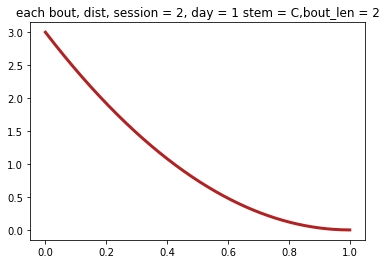

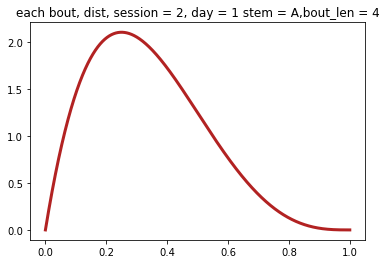

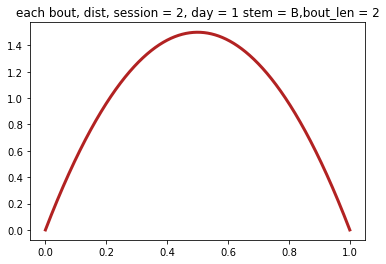

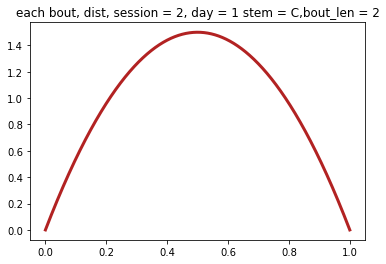

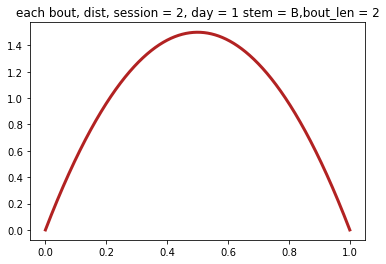

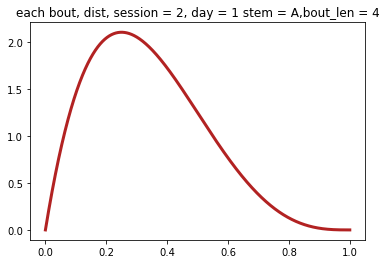

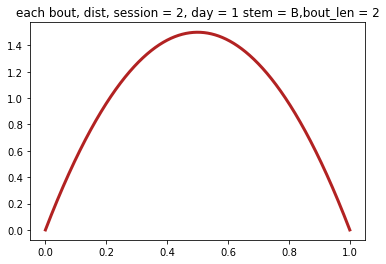

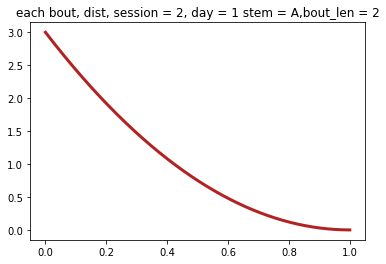

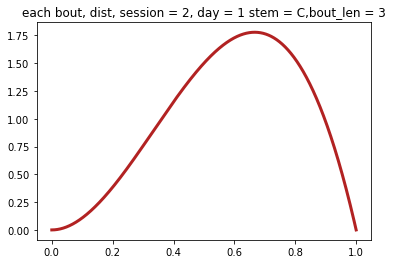

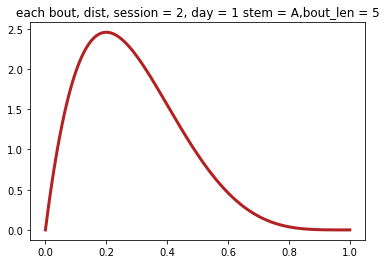

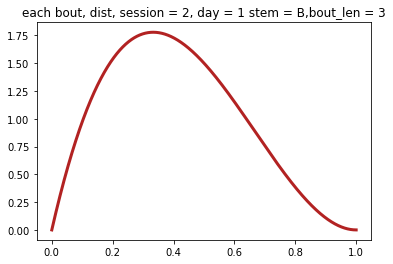

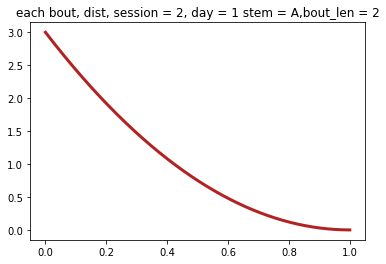

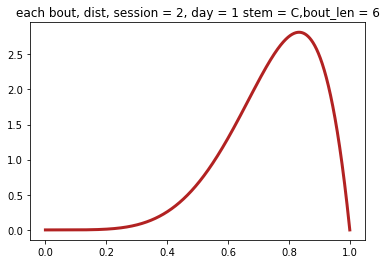

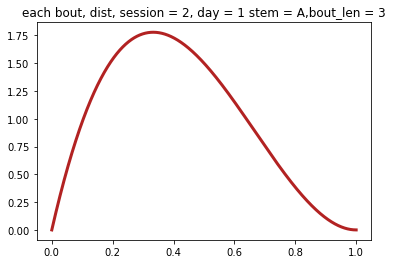

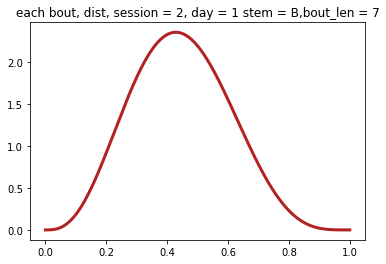

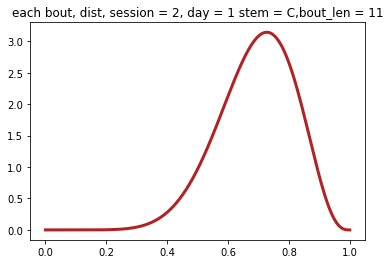

In [32]:
df_first_day = df[df['day']==1]
df_1_2 = df_first_day[df_first_day['session']==2]
df_1_2 = df_1_2[df_1_2['cont_num']==1]
bout = df_1_2[df_1_2.stem_switch==1]
# bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()

for ix in range(len(bout)):
    #bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()
    stem_bout=df_1_2[df_1_2['bout_num']==ix+(df_1_2['bout_num'].min())]
    num_trials=len(stem_bout)
    num_rewards = stem_bout['reward'].sum()    
    #num_rewards = stem_bout['rew_count'].max()
    num_failures = num_trials - num_rewards
    al = num_rewards+1
    bet = num_failures+1
    y1 = beta(al,bet)
    session = stem_bout['session'].iloc[0]
    day = stem_bout['day'].iloc[0]
    stem = stem_bout['stem'].iloc[0]
    x = np.linspace(0, 1, 10000)
    plt.figure()
    plt.plot(x, y1.pdf(x), linewidth=3, color='firebrick')
    plt.title(f'each bout, dist, session = {session}, day = {day} stem = {stem},bout_len = {num_trials}')

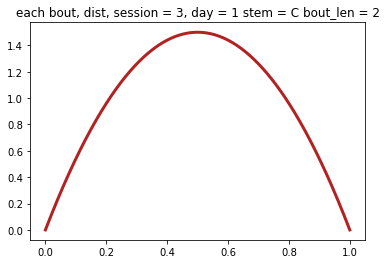

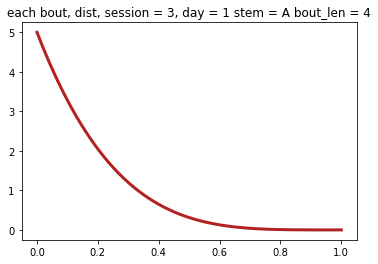

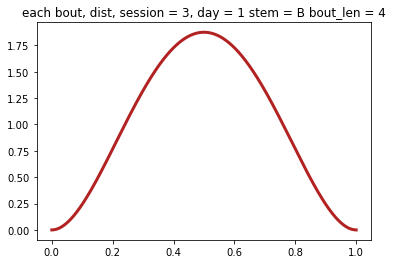

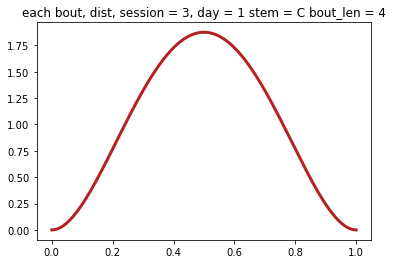

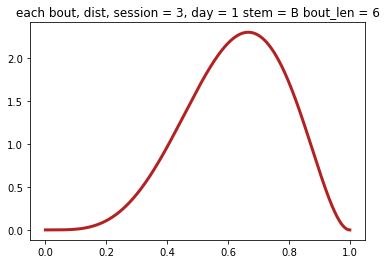

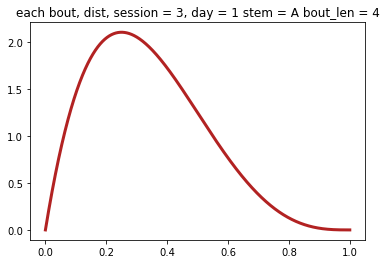

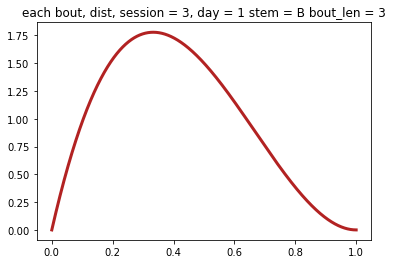

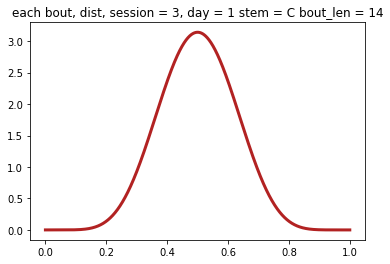

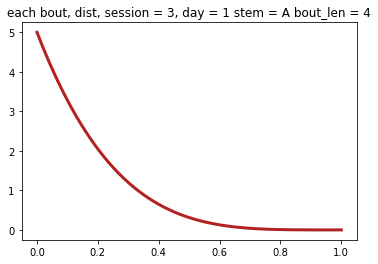

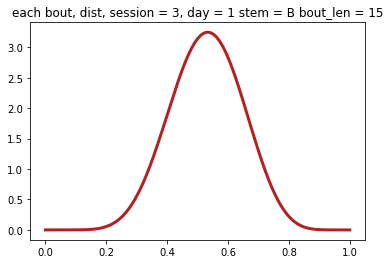

In [78]:
df_first_day = df[df['day']==1]
df_1_3 = df_first_day[df_first_day['session']==3]
df_1_3 = df_1_3[df_1_3['cont_num']==1]
bout = df_1_3[df_1_3.stem_switch==1]
# bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()

for ix in range(len(bout)):
    #bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()
    stem_bout=df_1_3[df_1_3['bout_num']==ix+(df_1_3['bout_num'].min())]
    num_trials=len(stem_bout)
    num_rewards = stem_bout['reward'].sum()    
    #num_rewards = stem_bout['rew_count'].max()
    num_failures = num_trials - num_rewards
    al = num_rewards+1
    bet = num_failures+1
    y1 = beta(al,bet)
    session = stem_bout['session'].iloc[0]
    day = stem_bout['day'].iloc[0]
    stem = stem_bout['stem'].iloc[0]
    x = np.linspace(0, 1, 10000)
    plt.figure()
    plt.plot(x, y1.pdf(x), linewidth=3, color='firebrick')
    plt.title(f'each bout, dist, session = {session}, day = {day} stem = {stem} bout_len = {num_trials}')

In [62]:
df_1_3

,Unnamed: 0,leaf,stem,reward,contingency,date,session,trial,day,cont_num,day_chng,stem_switch,bout_num,glob_nom_avg,sess_chng,rew_count,ChooseA,ChooseB,ChooseC,bout_num1
360,360,6,C,1,202080502080,20201028,3,0,1,1.0,False,True,53,45.0,3,1,0,0,1,53
361,361,5,C,0,202080502080,20201028,3,1,1,1.0,False,False,53,45.0,3,1,0,0,1,106
362,362,1,A,0,202080502080,20201028,3,2,1,1.0,False,True,54,45.0,3,0,1,0,0,160
363,363,2,A,0,202080502080,20201028,3,3,1,1.0,False,False,54,45.0,3,0,1,0,0,214
364,364,1,A,0,202080502080,20201028,3,4,1,1.0,False,False,54,45.0,3,0,1,0,0,268
365,365,2,A,0,202080502080,20201028,3,5,1,1.0,False,False,54,45.0,3,0,1,0,0,322
366,366,3,B,1,202080502080,20201028,3,6,1,1.0,False,True,55,45.0,3,1,0,1,0,377
367,367,4,B,0,202080502080,20201028,3,7,1,1.0,False,False,55,45.0,3,1,0,1,0,432
368,368,3,B,1,202080502080,20201028,3,8,1,1.0,False,False,55,45.0,3,2,0,1,0,487
369,369,4,B,0,202080502080,20201028,3,9,1,1.0,False,False,55,45.0,3,2,0,1,0,542


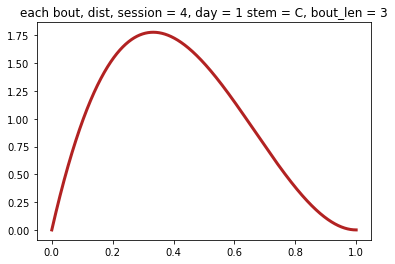

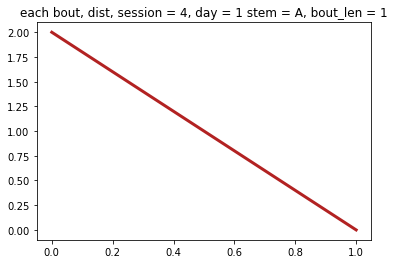

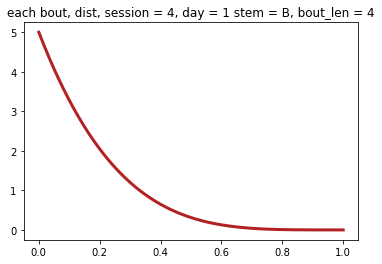

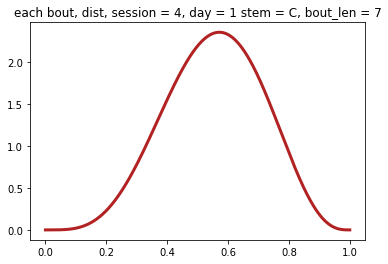

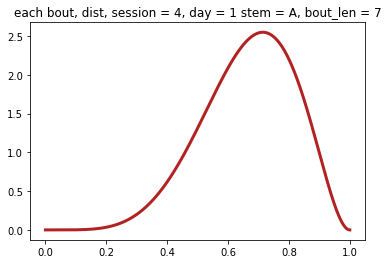

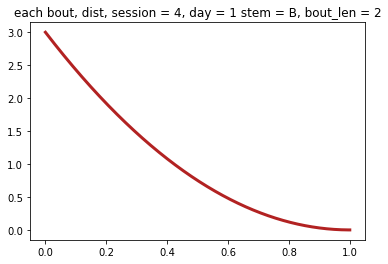

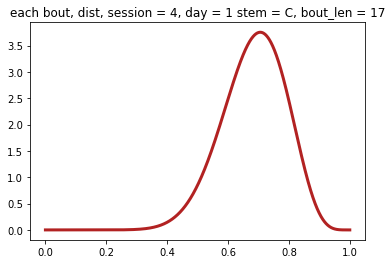

In [79]:
df_first_day = df[df['day']==1]
df_1_4 = df_first_day[df_first_day['session']==4]
df_1_4 = df_1_4[df_1_4['cont_num']==1]
bout = df_1_4[df_1_4.stem_switch==1]
# bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()

for ix in range(len(bout)):
    #bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()
    stem_bout=df_1_4[df_1_4['bout_num']==ix+(df_1_4['bout_num'].min())]
    num_trials=len(stem_bout)
    num_rewards = stem_bout['reward'].sum()    
    #num_rewards = stem_bout['rew_count'].max()
    num_failures = num_trials - num_rewards
    al = num_rewards+1
    bet = num_failures+1
    y1 = beta(al,bet)
    session = stem_bout['session'].iloc[0]
    day = stem_bout['day'].iloc[0]
    stem = stem_bout['stem'].iloc[0]
    x = np.linspace(0, 1, 10000)
    plt.figure()
    plt.plot(x, y1.pdf(x), linewidth=3, color='firebrick')
    plt.title(f'each bout, dist, session = {session}, day = {day} stem = {stem}, bout_len = {num_trials}')

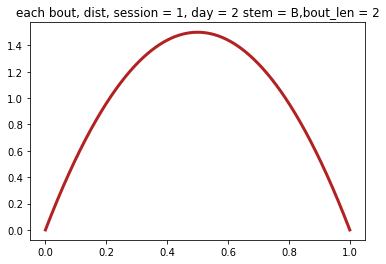

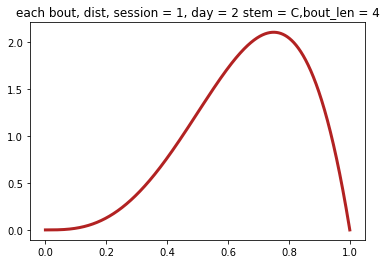

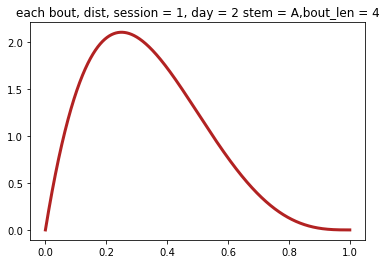

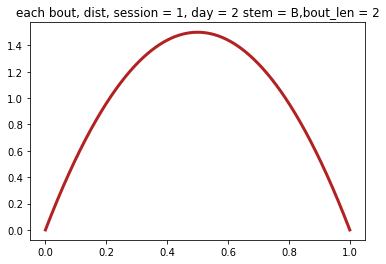

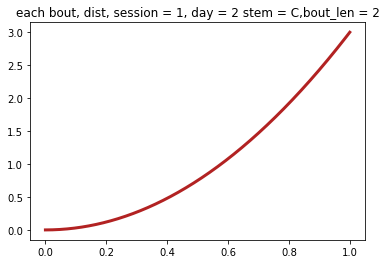

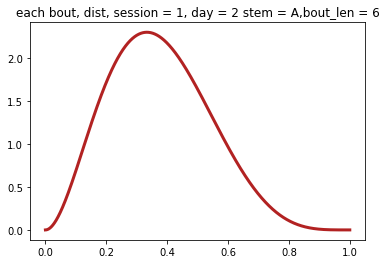

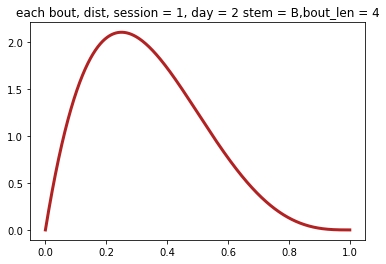

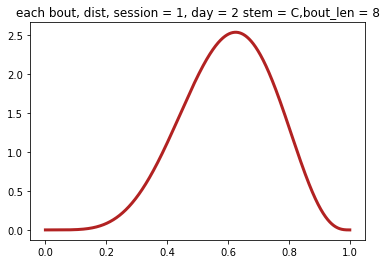

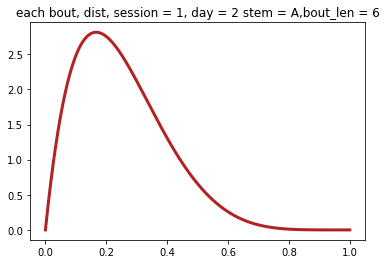

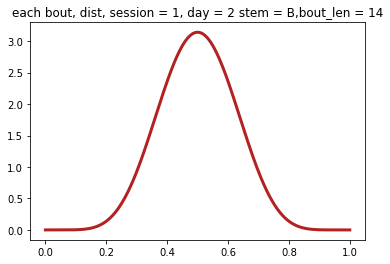

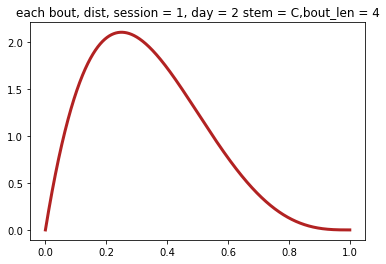

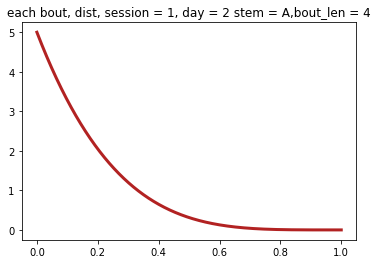

In [80]:
df_second_day = df[df['day']==2]
df_2_1 = df_second_day[df_second_day['session']==1]
df_2_1 = df_2_1[df_2_1['cont_num']==1]
bout = df_2_1[df_2_1.stem_switch==1]
# bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()

for ix in range(len(bout)):
    #bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()
    stem_bout=df_2_1[df_2_1['bout_num']==ix+(df_2_1['bout_num'].min())]
    num_trials=len(stem_bout)
    num_rewards = stem_bout['reward'].sum()    
    #num_rewards = stem_bout['rew_count'].max()
    num_failures = num_trials - num_rewards
    al = num_rewards+1
    bet = num_failures+1
    y1 = beta(al,bet)
    session = stem_bout['session'].iloc[0]
    day = stem_bout['day'].iloc[0]
    stem = stem_bout['stem'].iloc[0]
    x = np.linspace(0, 1, 10000)
    plt.figure()
    plt.plot(x, y1.pdf(x), linewidth=3, color='firebrick')
    plt.title(f'each bout, dist, session = {session}, day = {day} stem = {stem},bout_len = {num_trials}')

In [81]:
df_2_1

,Unnamed: 0,leaf,stem,reward,contingency,date,session,trial,day,cont_num,day_chng,stem_switch,bout_num,glob_nom_avg,sess_chng,rew_count,ChooseA,ChooseB,ChooseC,bout_num1
720,720,3,B,0,202020505080,20201029,1,0,2,1.0,True,True,83,40.0,5,0,0,1,0,83
721,721,4,B,1,202020505080,20201029,1,1,2,1.0,False,False,83,40.0,5,1,0,1,0,166
722,722,5,C,1,202020505080,20201029,1,2,2,1.0,False,True,84,40.0,5,1,0,0,1,250
723,723,6,C,1,202020505080,20201029,1,3,2,1.0,False,False,84,40.0,5,2,0,0,1,334
724,724,5,C,0,202020505080,20201029,1,4,2,1.0,False,False,84,40.0,5,2,0,0,1,418
725,725,6,C,1,202020505080,20201029,1,5,2,1.0,False,False,84,40.0,5,3,0,0,1,502
726,726,1,A,0,202020505080,20201029,1,6,2,1.0,False,True,85,40.0,5,0,1,0,0,587
727,727,2,A,0,202020505080,20201029,1,7,2,1.0,False,False,85,40.0,5,0,1,0,0,672
728,728,1,A,1,202020505080,20201029,1,8,2,1.0,False,False,85,40.0,5,1,1,0,0,757
729,729,2,A,0,202020505080,20201029,1,9,2,1.0,False,False,85,40.0,5,1,1,0,0,842


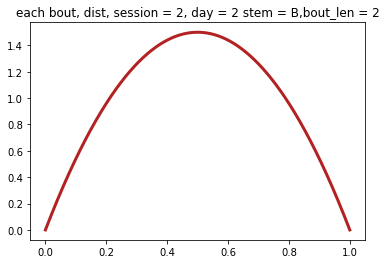

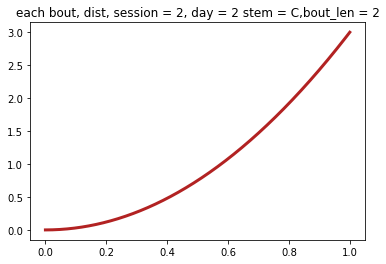

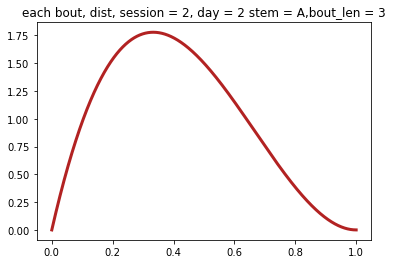

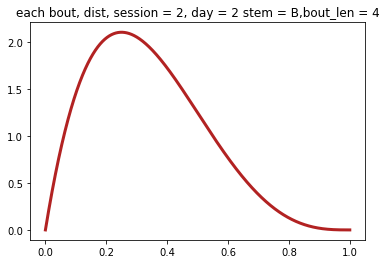

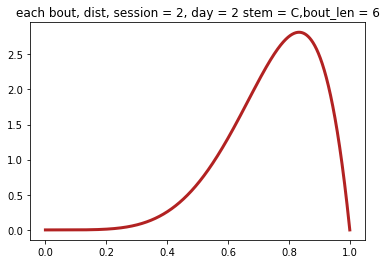

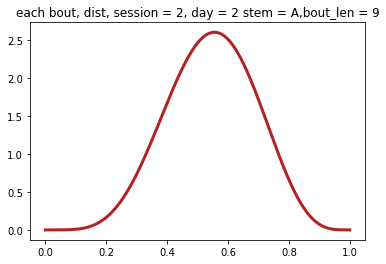

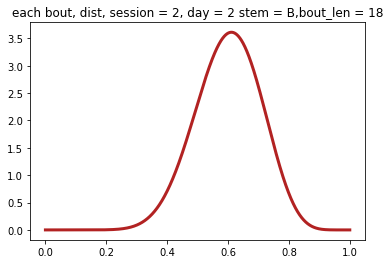

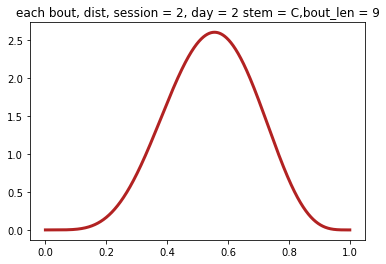

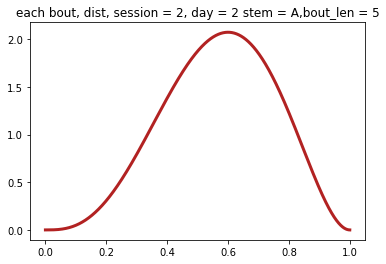

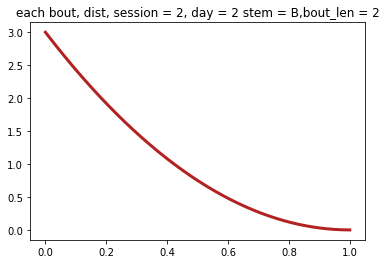

In [82]:
df_second_day = df[df['day']==2]
df_2_2 = df_second_day[df_second_day['session']==2]
df_2_2 = df_2_2[df_2_2['cont_num']==1]
bout = df_2_2[df_2_2.stem_switch==1]
# bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()

for ix in range(len(bout)):
    #bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()
    stem_bout=df_2_2[df_2_2['bout_num']==ix+(df_2_2['bout_num'].min())]
    num_trials=len(stem_bout)
    num_rewards = stem_bout['reward'].sum()    
    #num_rewards = stem_bout['rew_count'].max()
    num_failures = num_trials - num_rewards
    al = num_rewards+1
    bet = num_failures+1
    y1 = beta(al,bet)
    session = stem_bout['session'].iloc[0]
    day = stem_bout['day'].iloc[0]
    stem = stem_bout['stem'].iloc[0]
    x = np.linspace(0, 1, 10000)
    plt.figure()
    plt.plot(x, y1.pdf(x), linewidth=3, color='firebrick')
    plt.title(f'each bout, dist, session = {session}, day = {day} stem = {stem},bout_len = {num_trials}')

In [83]:
df_2_2

,Unnamed: 0,leaf,stem,reward,contingency,date,session,trial,day,cont_num,day_chng,stem_switch,bout_num,glob_nom_avg,sess_chng,rew_count,ChooseA,ChooseB,ChooseC,bout_num1
900,900,4,B,1,502020808050,20201029,2,0,2,1.0,False,True,100,50.0,6,1,0,1,0,100
901,901,3,B,0,502020808050,20201029,2,1,2,1.0,False,False,100,50.0,6,1,0,1,0,200
902,902,5,C,1,502020808050,20201029,2,2,2,1.0,False,True,101,50.0,6,1,0,0,1,301
903,903,6,C,1,502020808050,20201029,2,3,2,1.0,False,False,101,50.0,6,2,0,0,1,402
904,904,1,A,0,502020808050,20201029,2,4,2,1.0,False,True,102,50.0,6,0,1,0,0,504
905,905,2,A,0,502020808050,20201029,2,5,2,1.0,False,False,102,50.0,6,0,1,0,0,606
906,906,1,A,1,502020808050,20201029,2,6,2,1.0,False,False,102,50.0,6,1,1,0,0,708
907,907,3,B,0,502020808050,20201029,2,7,2,1.0,False,True,103,50.0,6,1,0,1,0,811
908,908,4,B,0,502020808050,20201029,2,8,2,1.0,False,False,103,50.0,6,1,0,1,0,914
909,909,3,B,0,502020808050,20201029,2,9,2,1.0,False,False,103,50.0,6,1,0,1,0,1017


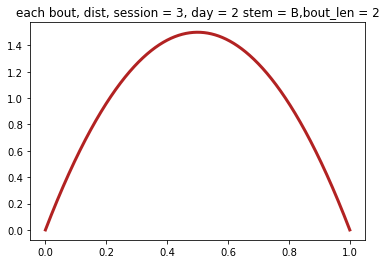

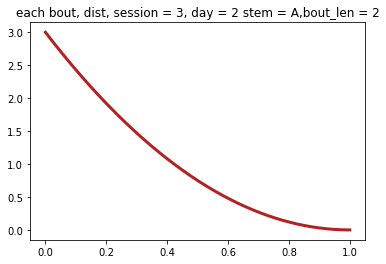

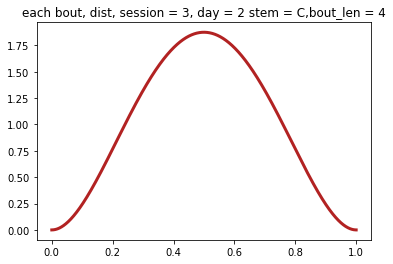

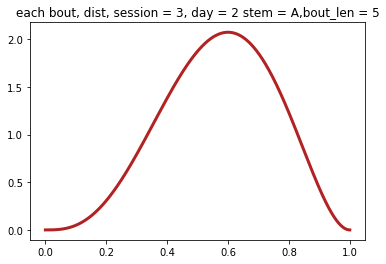

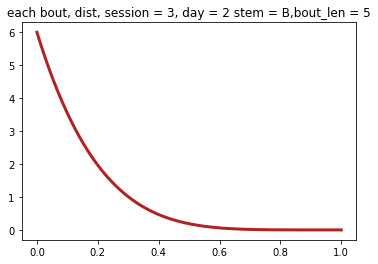

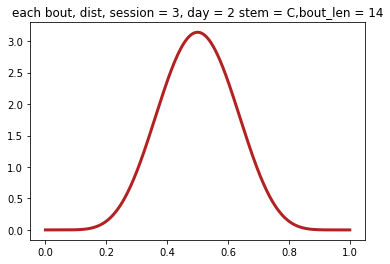

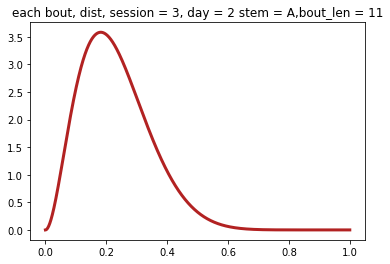

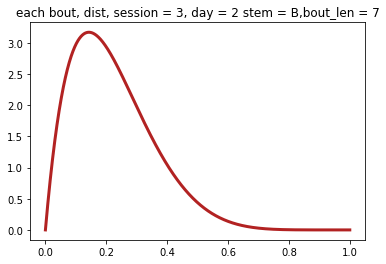

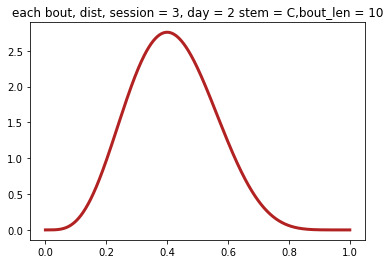

In [84]:
df_second_day = df[df['day']==2]
df_2_3 = df_second_day[df_second_day['session']==3]
df_2_3 = df_2_3[df_2_3['cont_num']==1]
bout = df_2_3[df_2_3.stem_switch==1]
# bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()

for ix in range(len(bout)):
    #bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()
    stem_bout=df_2_3[df_2_3['bout_num']==ix+(df_2_3['bout_num'].min())]
    num_trials=len(stem_bout)
    num_rewards = stem_bout['reward'].sum()    
    #num_rewards = stem_bout['rew_count'].max()
    num_failures = num_trials - num_rewards
    al = num_rewards+1
    bet = num_failures+1
    y1 = beta(al,bet)
    session = stem_bout['session'].iloc[0]
    day = stem_bout['day'].iloc[0]
    stem = stem_bout['stem'].iloc[0]
    x = np.linspace(0, 1, 10000)
    plt.figure()
    plt.plot(x, y1.pdf(x), linewidth=3, color='firebrick')
    plt.title(f'each bout, dist, session = {session}, day = {day} stem = {stem},bout_len = {num_trials}')

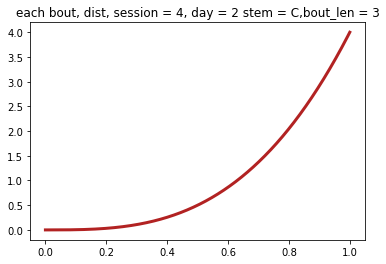

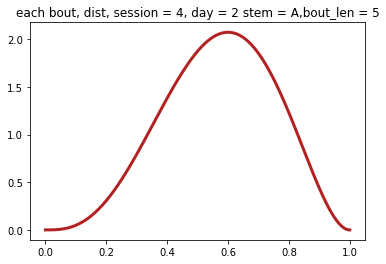

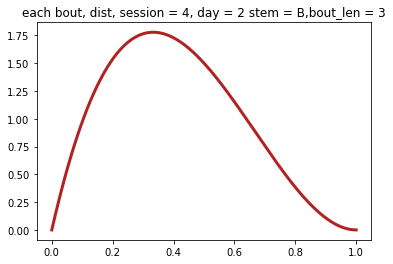

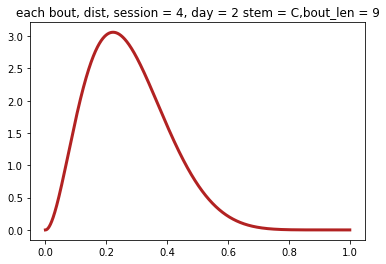

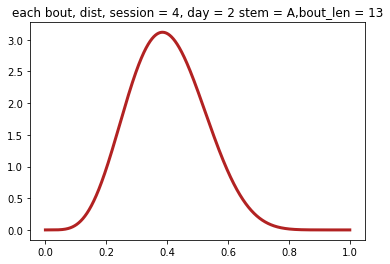

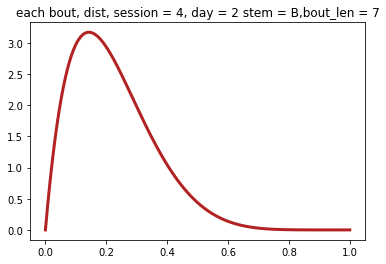

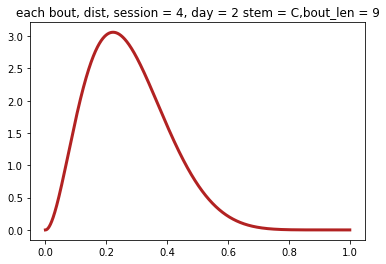

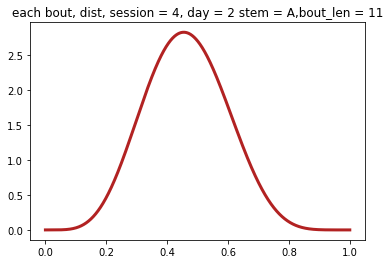

In [86]:
df_second_day = df[df['day']==2]
df_2_4 = df_second_day[df_second_day['session']==4]
df_2_4 = df_2_4[df_2_4['cont_num']==1]
bout = df_2_4[df_2_4.stem_switch==1]
# bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()

for ix in range(len(bout)):
    #bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()
    stem_bout=df_2_4[df_2_4['bout_num']==ix+(df_2_4['bout_num'].min())]
    num_trials=len(stem_bout)
    num_rewards = stem_bout['reward'].sum()    
    #num_rewards = stem_bout['rew_count'].max()
    num_failures = num_trials - num_rewards
    al = num_rewards+1
    bet = num_failures+1
    y1 = beta(al,bet)
    session = stem_bout['session'].iloc[0]
    day = stem_bout['day'].iloc[0]
    stem = stem_bout['stem'].iloc[0]
    x = np.linspace(0, 1, 10000)
    plt.figure()
    plt.plot(x, y1.pdf(x), linewidth=3, color='firebrick')
    plt.title(f'each bout, dist, session = {session}, day = {day} stem = {stem},bout_len = {num_trials}')

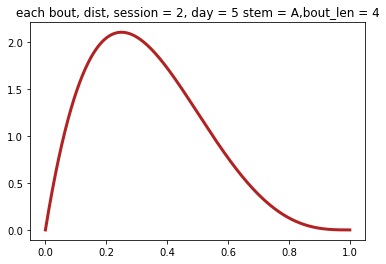

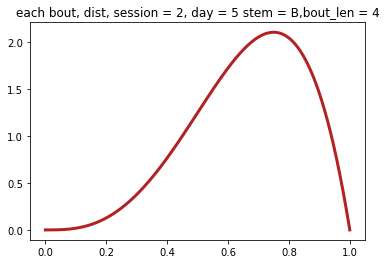

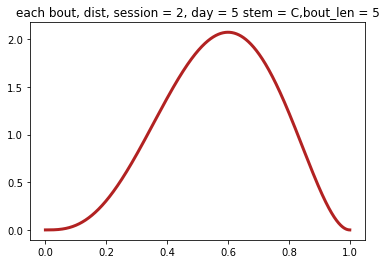

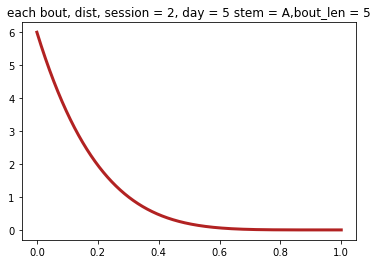

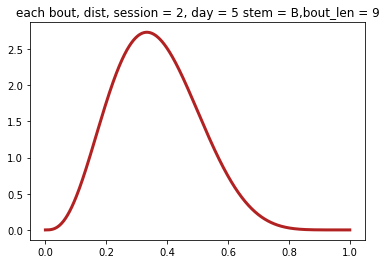

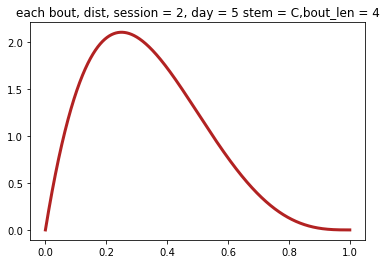

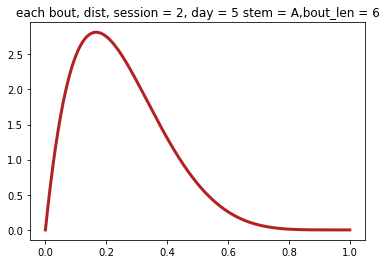

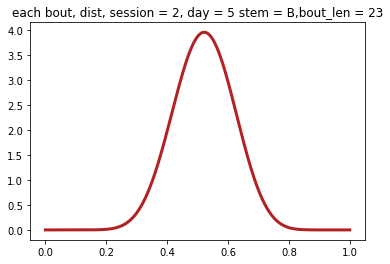

In [88]:
df_fifth_day = df[df['day']==5]
df_5_2 = df_fifth_day[df_fifth_day['session']==2]
df_5_2 = df_5_2[df_5_2['cont_num']==1]
bout = df_5_2[df_5_2.stem_switch==1]
# bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()

for ix in range(len(bout)+1):
    #bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()
    stem_bout=df_5_2[df_5_2['bout_num']==ix+(df_5_2['bout_num'].min())]
    num_trials=len(stem_bout)
    num_rewards = stem_bout['reward'].sum()    
    #num_rewards = stem_bout['rew_count'].max()
    num_failures = num_trials - num_rewards
    al = num_rewards+1
    bet = num_failures+1
    y1 = beta(al,bet)
    session = stem_bout['session'].iloc[0]
    day = stem_bout['day'].iloc[0]
    stem = stem_bout['stem'].iloc[0]
    x = np.linspace(0, 1, 10000)
    plt.figure()
    plt.plot(x, y1.pdf(x), linewidth=3, color='firebrick')
    plt.title(f'each bout, dist, session = {session}, day = {day} stem = {stem},bout_len = {num_trials}')

IndexError: single positional indexer is out-of-bounds

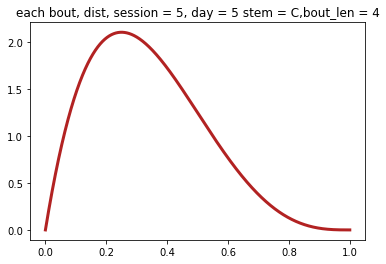

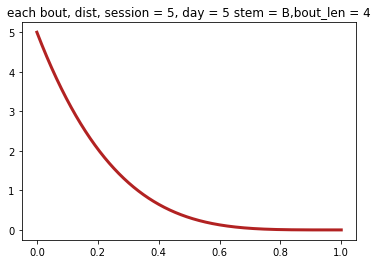

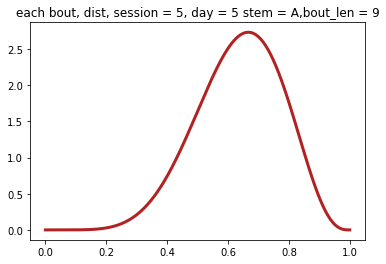

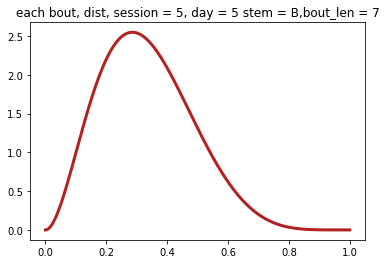

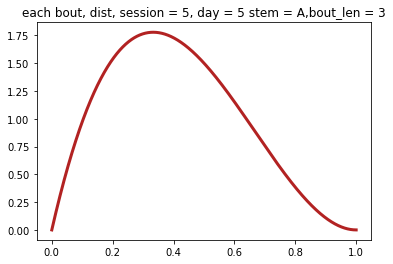

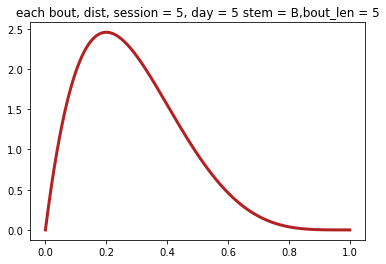

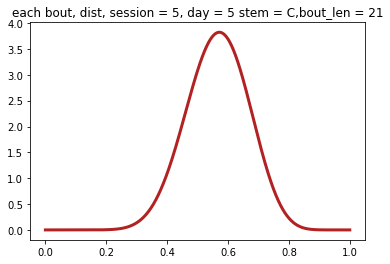

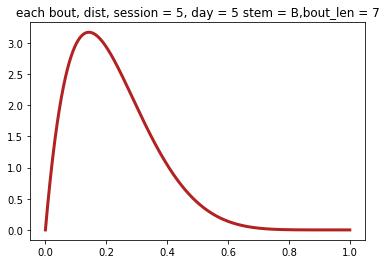

In [90]:
df_fifth_day = df[df['day']==5]
df_5_5 = df_fifth_day[df_fifth_day['session']==5]
df_5_5 = df_5_5[df_5_5['cont_num']==1]
bout = df_5_5[df_5_5.stem_switch==1]
# bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()

for ix in range(len(bout)+1):
    #bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()
    stem_bout=df_5_5[df_5_5['bout_num']==ix+(df_5_5['bout_num'].min())]
    num_trials=len(stem_bout)
    num_rewards = stem_bout['reward'].sum()    
    #num_rewards = stem_bout['rew_count'].max()
    num_failures = num_trials - num_rewards
    al = num_rewards+1
    bet = num_failures+1
    y1 = beta(al,bet)
    session = stem_bout['session'].iloc[0]
    day = stem_bout['day'].iloc[0]
    stem = stem_bout['stem'].iloc[0]
    x = np.linspace(0, 1, 10000)
    plt.figure()
    plt.plot(x, y1.pdf(x), linewidth=3, color='firebrick')
    plt.title(f'each bout, dist, session = {session}, day = {day} stem = {stem},bout_len = {num_trials}')

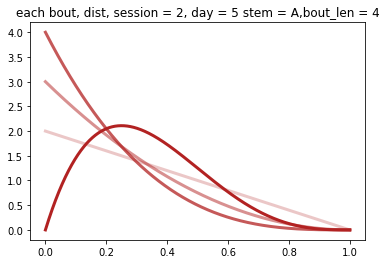

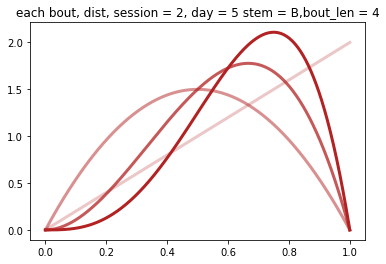

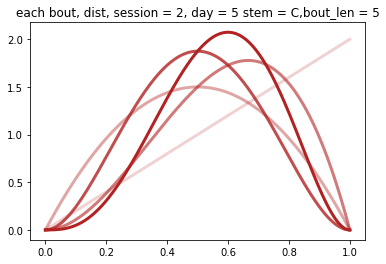

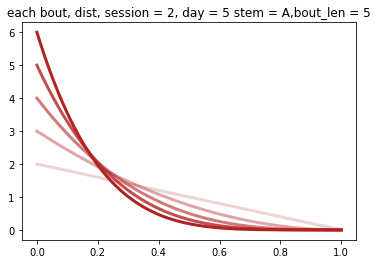

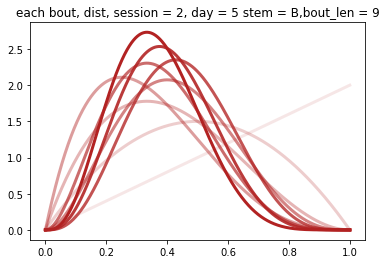

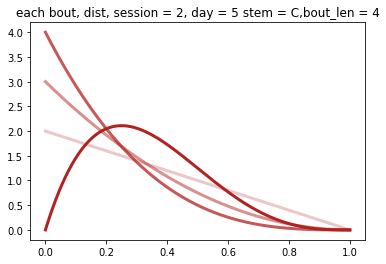

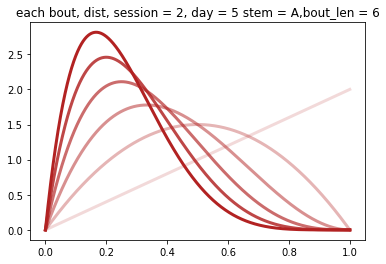

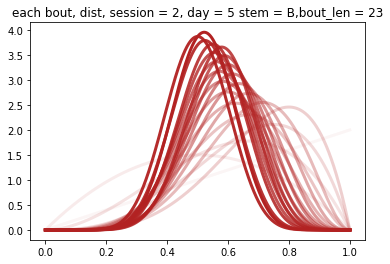

In [116]:
df_fifth_day = df[df['day']==5]
df_5_2 = df_fifth_day[df_fifth_day['session']==2]
df_5_2 = df_5_2[df_5_2['cont_num']==1]
bout = df_5_2[df_5_2.stem_switch==1]
# bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()

for ix in range(len(bout)+1):
    #bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()
    stem_bout=df_5_2[df_5_2['bout_num']==ix+(df_5_2['bout_num'].min())]
    plt.figure()
    #plt.annotate(f'bout len={len(stem_bout)}',xy=(.5,1))
    for ix2 in range(len(stem_bout)):
        stem_bout_trial = stem_bout.iloc[0:ix2+1]
        num_trials=len(stem_bout_trial)
        num_rewards = stem_bout_trial['reward'].sum()    
        #num_rewards = stem_bout['rew_count'].max()
        num_failures = num_trials - num_rewards
        al = num_rewards+1
        bet = num_failures+1
        y1 = beta(al,bet)
        session = stem_bout['session'].iloc[0]
        day = stem_bout['day'].iloc[0]
        stem = stem_bout['stem'].iloc[0]
        x = np.linspace(0, 1, 10000)
        plt.plot(x, y1.pdf(x), linewidth=3, color='firebrick',alpha=num_trials/len(stem_bout))
        plt.title(f'each bout, dist, session = {session}, day = {day} stem = {stem},bout_len = {num_trials}')

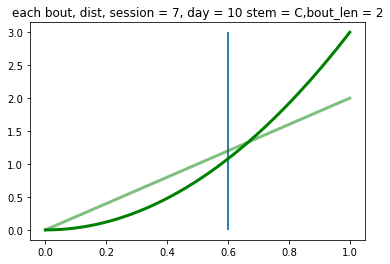

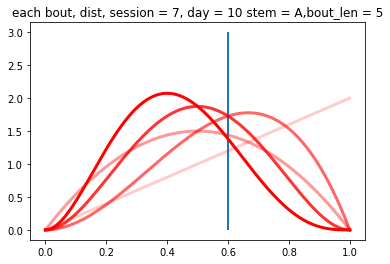

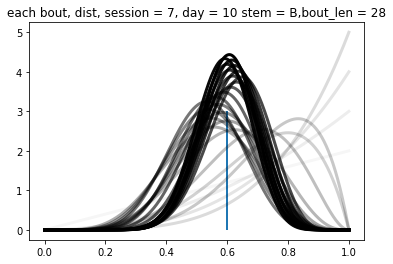

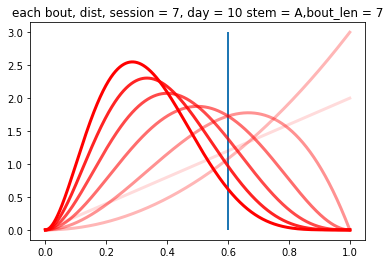

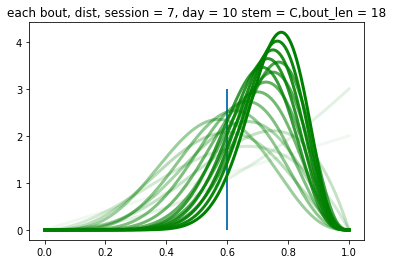

<Figure size 432x288 with 0 Axes>

In [134]:
df_day = df[df['day']==10]
df_day_sesh = df_day[df_day['session']==7]
df_day_sesh = df_day_sesh[df_day_sesh['cont_num']==1]
bout = df_day_sesh[df_day_sesh.stem_switch==1]
#bout is the df with every first trial after stem switch- to find indexes for the start of each bout

for ix in range(len(bout)+1):
    #bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()
    stem_bout=df_day_sesh[df_day_sesh['bout_num']==ix+(df_day_sesh['bout_num'].min())]
    plt.figure()
    #plt.annotate(f'bout len={len(stem_bout)}',xy=(.5,1))
    for ix2 in range(len(stem_bout)):
        stem_bout_trial = stem_bout.iloc[0:ix2+1]
        num_trials=len(stem_bout_trial)
        num_rewards = stem_bout_trial['reward'].sum()    
        #num_rewards = stem_bout['rew_count'].max()
        num_failures = num_trials - num_rewards
        al = num_rewards+1
        bet = num_failures+1
        y1 = beta(al,bet)
        session = stem_bout['session'].iloc[0]
        day = stem_bout['day'].iloc[0]
        stem = stem_bout['stem'].iloc[0]
        x = np.linspace(0, 1, 10000)
        if stem == "A":
            colors= 'red'
        elif stem == 'B':
            colors = 'black'
        elif stem=='C':
            colors = 'green'
        plt.plot(x, y1.pdf(x), linewidth=3, color=colors,alpha=num_trials/len(stem_bout))
        plt.vlines(.6,0,3)
        plt.title(f'each bout, dist, session = {session}, day = {day} stem = {stem},bout_len = {num_trials}')

In [135]:
bout

,Unnamed: 0,leaf,stem,reward,contingency,date,session,trial,day,cont_num,day_chng,stem_switch,bout_num,glob_nom_avg,sess_chng,rew_count,ChooseA,ChooseB,ChooseC,bout_num1
11853,11853,6,C,1,205080205080,20201106,7,0,10,1.0,False,True,746,50.0,67,1,0,0,1,746
11855,11855,2,A,1,205080205080,20201106,7,2,10,1.0,False,True,747,50.0,67,1,1,0,0,2239
11860,11860,4,B,1,205080205080,20201106,7,7,10,1.0,False,True,748,50.0,67,1,0,1,0,5975
11888,11888,2,A,1,205080205080,20201106,7,35,10,1.0,False,True,749,50.0,67,3,1,0,0,26920
11895,11895,5,C,1,205080205080,20201106,7,42,10,1.0,False,True,750,50.0,67,3,0,0,1,32164


In [106]:
#what if I do the same but now have him have perfect memory? 

,Unnamed: 0,leaf,stem,reward,contingency,date,session,trial,day,cont_num,day_chng,stem_switch,bout_num,glob_nom_avg,sess_chng,rew_count,ChooseA,ChooseB,ChooseC,bout_num1
10233,10233,4,B,1,502020208020,20201105,5,0,9,1.0,False,True,653,35.0,58,1,0,1,0,653


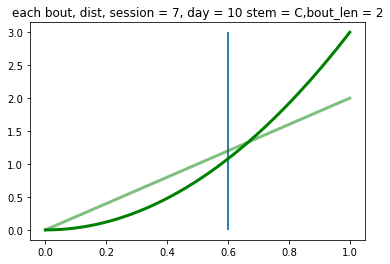

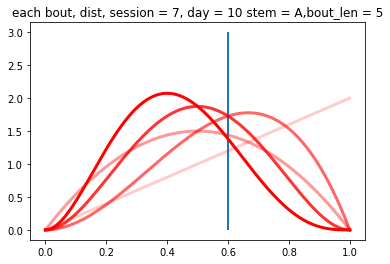

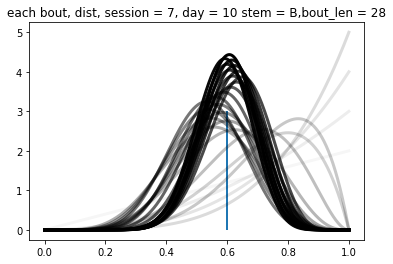

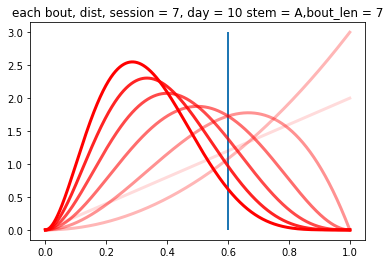

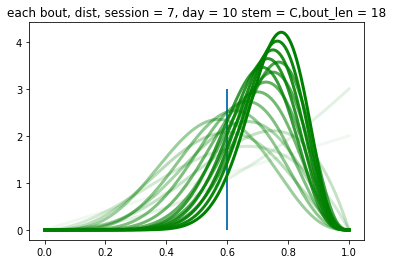

<Figure size 432x288 with 0 Axes>

In [33]:
df_day = df[df['day']==10]
df_day_sesh = df_day[df_day['session']==7]
df_day_sesh = df_day_sesh[df_day_sesh['cont_num']==1]
bout = df_day_sesh[df_day_sesh.stem_switch==1]
#bout is the df with every first trial after stem switch- to find indexes for the start of each bout

for ix in range(len(bout)+1):
    #bout['bout_num1'] = bout['bout_num'].ne(bout['bout_num'].shift()).cumsum()
    stem_bout=df_day_sesh[df_day_sesh['bout_num']==ix+(df_day_sesh['bout_num'].min())]
    plt.figure()
    #plt.annotate(f'bout len={len(stem_bout)}',xy=(.5,1))
    for ix2 in range(len(stem_bout)):
        stem_bout_trial = stem_bout.iloc[0:ix2+1]
        num_trials=len(stem_bout_trial)
        num_rewards = stem_bout_trial['reward'].sum()    
        #num_rewards = stem_bout['rew_count'].max()
        num_failures = num_trials - num_rewards
        al = num_rewards+1
        bet = num_failures+1
        y1 = beta(al,bet)
        session = stem_bout['session'].iloc[0]
        day = stem_bout['day'].iloc[0]
        stem = stem_bout['stem'].iloc[0]
        x = np.linspace(0, 1, 10000)
        if stem == "A":
            colors= 'red'
        elif stem == 'B':
            colors = 'black'
        elif stem=='C':
            colors = 'green'
        plt.plot(x, y1.pdf(x), linewidth=3, color=colors,alpha=num_trials/len(stem_bout))
        plt.vlines(.6,0,3)
        plt.title(f'each bout, dist, session = {session}, day = {day} stem = {stem},bout_len = {num_trials}')

1

1

0